In [1]:
import osmnx as ox
%matplotlib inline

In [2]:
ox.config(log_file=True, log_console=True, use_cache=True)

Create a street network and then simplify it

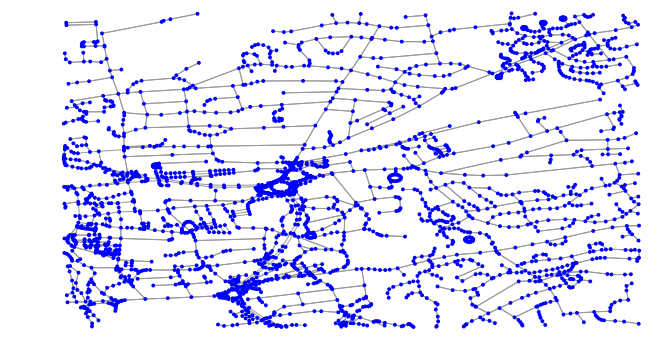

In [24]:
# create a network around some (lat, lon) point and plot it
location_point = (56.073776,  -3.448697)
G = ox.graph_from_point(location_point, distance=1000, simplify=False)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)

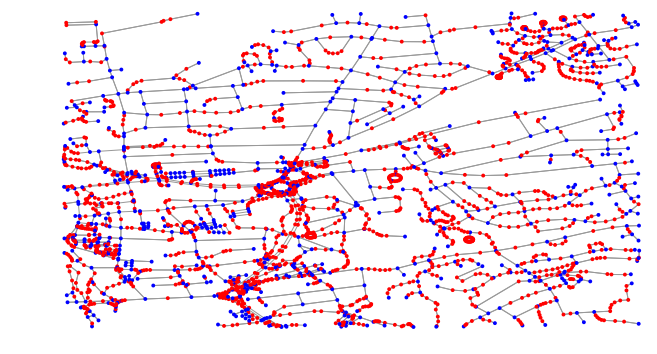

In [25]:
# show which nodes we'd remove if we simplify it
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

In [26]:
# simplify the network
G2 = G.copy()
G2 = ox.simplify_graph(G2)

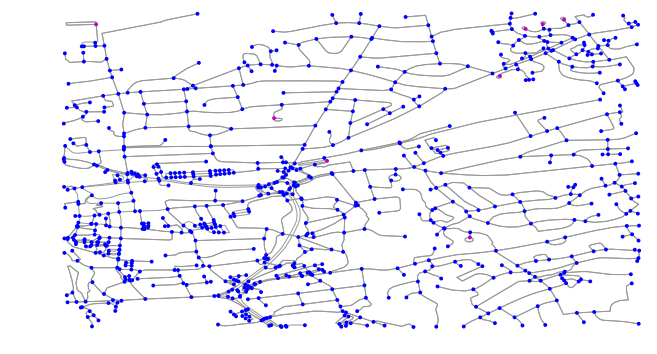

In [27]:
# plot the simplified network and show any loops in magenta
loops = [edge[0] for edge in G2.selfloop_edges()]
nc = ['m' if node in loops else 'b' for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc, node_zorder=3)

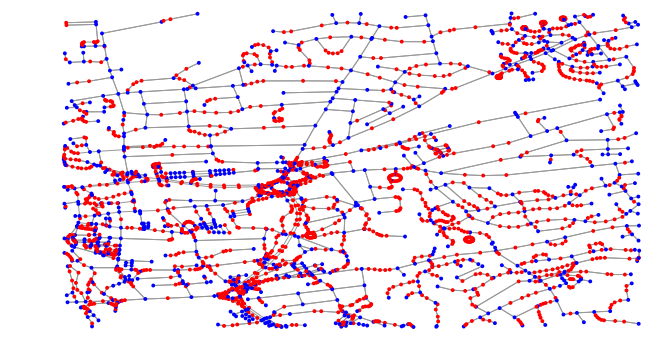

In [28]:
# turn off strict mode and see what nodes we'd remove
nc = ['b' if ox.is_endpoint(G, node, strict=False) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

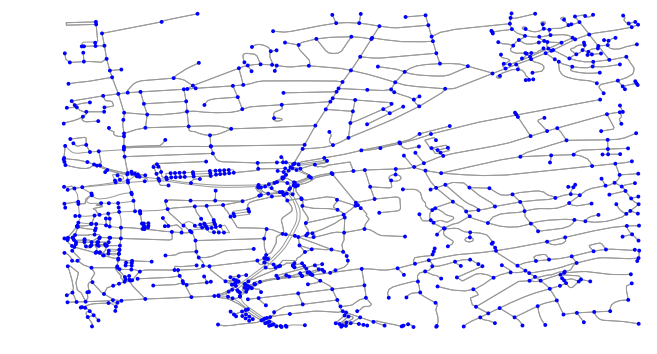

In [29]:
# simplify network with strict mode turned off
G3 = G.copy()
G3 = ox.simplify_graph(G3, strict=False)
fig, ax = ox.plot_graph(G3, node_color='b', node_zorder=3)

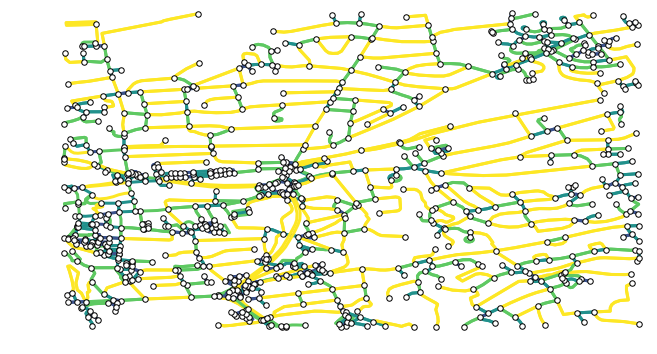

In [30]:
# show the strictly simplified network with edges colored by network length
ec = ox.get_edge_colors_by_attr(G2, attr='length')
fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=30, node_zorder=3, edge_color=ec, edge_linewidth=3)

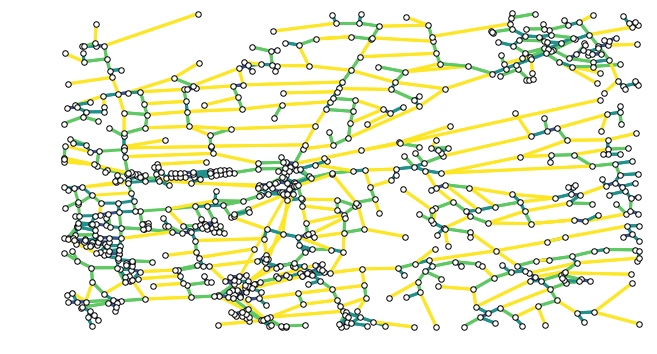

In [31]:
# plot same network again (topologically isomorphic), this time ignoring the edges' spatial geometry
ec = ox.get_edge_colors_by_attr(G2, attr='length')
fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=30, node_zorder=3, 
                           edge_color=ec, edge_linewidth=3, edge_alpha=1, use_geom=False)

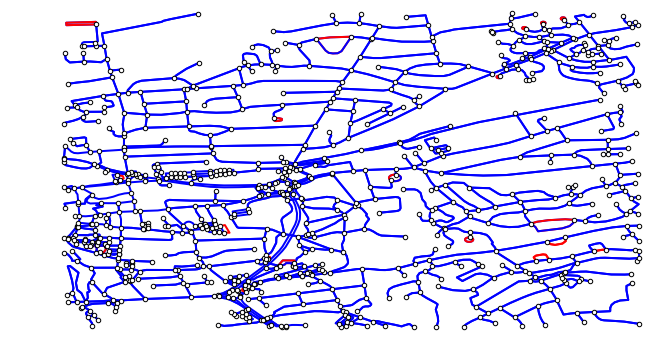

In [32]:
# highlight all parallel edges
ec = ['b' if key == 0 else 'r' for u, v, key in G2.edges(keys=True)]
fig, ax = ox.plot_graph(G2, node_color='w', node_edgecolor='k', node_size=20, node_zorder=3, edge_color=ec, edge_linewidth=2)

Cleaning up the periphery of the network
This is related to simplification. OSMnx by default (with clean_periphery parameter equal to True) buffers the area you request by 0.5km, and then retrieves the street network within this larger, buffered area. Then it simplifies the topology so that nodes represent intersections of streets (rather than including all the interstitial OSM nodes). Then it calculates the (undirected) degree of each node in this larger network. Next it truncates this network by the actual area you requested (either by bounding box, or by polygon). Finally it saves a dictionary of node degree values as a graph attribute.
This has two primary benefits. First, it cleans up stray false edges around the periphery. If clean_periphery=False, peripheral non-intersection nodes within the requested area appear to be cul-de-sacs, as the rest of the edge leading to an intersection outside the area is ignored. If clean_periphery=True, the larger graph is first created, allowing simplification of such edges to their true intersections, allowing their entirety to be pruned after truncating down to the actual requested area. Second, it gives accurate node degrees by both a) counting node neighbors even if they fall outside the retained network (so you don't claim a degree-4 node is degree-2 because only 2 of its neighbors lie within the area), and b) not counting all those stray false edges' terminus nodes as cul-de-sacs that otherwise grossly inflate the count of nodes with degree=1, even though these nodes are really just interstitial nodes in the middle of a chopped-off street segment between intersections.
See two examples below.

In [35]:
# get some bbox
bbox = ox.bbox_from_point((56.073776,  -3.448697), distance=1000)
north, south, east, west = bbox

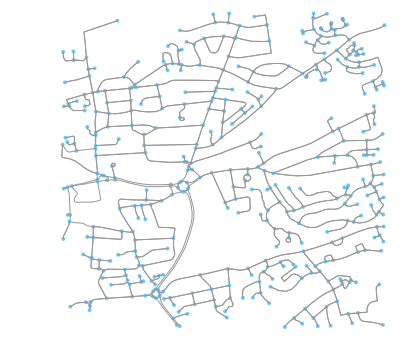

In [36]:
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', clean_periphery=False)
fig, ax = ox.plot_graph(ox.project_graph(G))

In [37]:
# the node degree distribution for this graph has many false cul-de-sacs
k = dict(G.degree())
{n:list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 3, 2: 141, 3: 8, 4: 9, 5: 27, 6: 225, 7: 0, 8: 12}

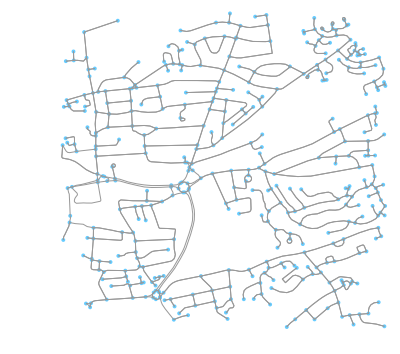

In [38]:
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
fig, ax = ox.plot_graph(ox.project_graph(G))

In [39]:
# the streets_per_node distribution for this cleaned up graph is more accurate
# dict keys = count of streets emanating from the node (ie, intersections and dead-ends)
# dict vals = number of nodes with that count
k = G.graph['streets_per_node']
{n:list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 118, 2: 0, 3: 273, 4: 22}

### Save a shapefile

In [40]:
# save as ESRI shapefile
ox.save_graph_shapefile(G, filename='Appin_Crescent')

### Highlight one way street

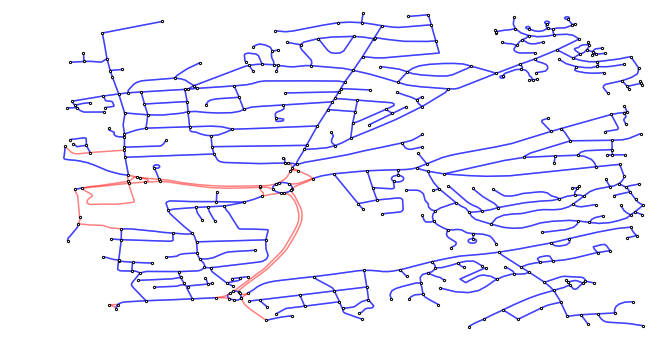

In [41]:
# highlight one-way streets
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=5, node_zorder=3, 
                           edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

Save building footprints as a shapefile¶

In [42]:
gdf = ox.buildings_from_place(place= 'Dunfermline, UK')
gdf.drop(labels='nodes', axis=1).to_file('data/Dunfermline_bldngs')